In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
import time

import utils
import plot
import metrics

from svgd import SVGD, get_bandwidth

rkey = random.PRNGKey(0)

In [2]:
from jax.scipy.stats import multivariate_normal
mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])
assert utils.is_pd(cov)
logp22 = lambda x: multivariate_normal.logpdf(x, mean, cov)

In [3]:
n = 100
d = 2
stepsize = 0.01
L = int(3 / stepsize)

svgd_adaptive22 = SVGD(logp=logp22, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [4]:
svgd_adaptive22.newkey()
xout22, log22 = svgd_adaptive22.svgd(svgd_adaptive22.rkey, stepsize, bandwidth=0, n_iter=L)
xout22.block_until_ready()
print()

JIT COMPILING svgd...
...done compiling svgd after 0.4709300994873047 seconds.



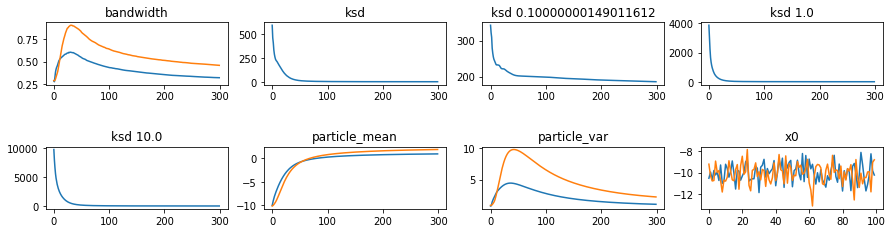

In [5]:
import matplotlib as mpl

plt.figure(1, figsize=[15, 8])
plt.subplots_adjust(hspace=1)

l = len(log22)
k = l // 2
for i, key in enumerate(log22.keys()):
    plt.subplot(f"{l-k}{k}{i+1}") # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
    plt.title(key)
    plt.plot(log22[key])

var [1.0337311 2.210293 ]
mean: [0.88810956 1.8170495 ]


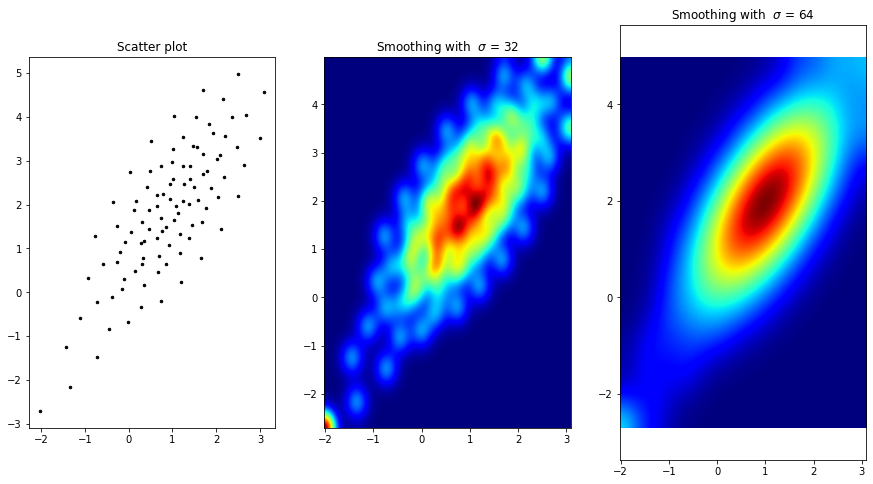

In [38]:
print("var", np.var(xout22, axis=0))
print("mean:", np.mean(xout22, axis=0))

plot.bivariate_hist(xout22)

Comparison histogram:

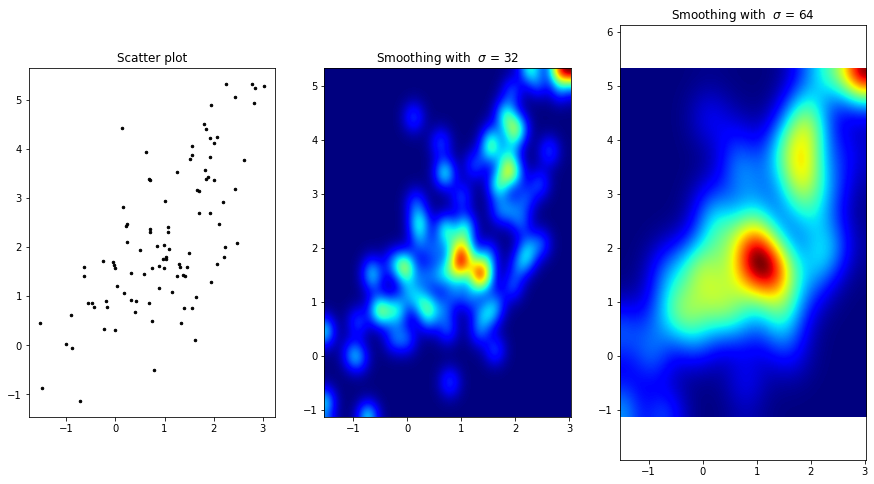

var [1.0403998 2.1797109]
mean: [1.0045718 2.170072 ]


In [39]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean, cov, shape=(100,))

plot.bivariate_hist(xtest)
print("var", np.var(xtest, axis=0))
print("mean:", np.mean(xtest, axis=0))

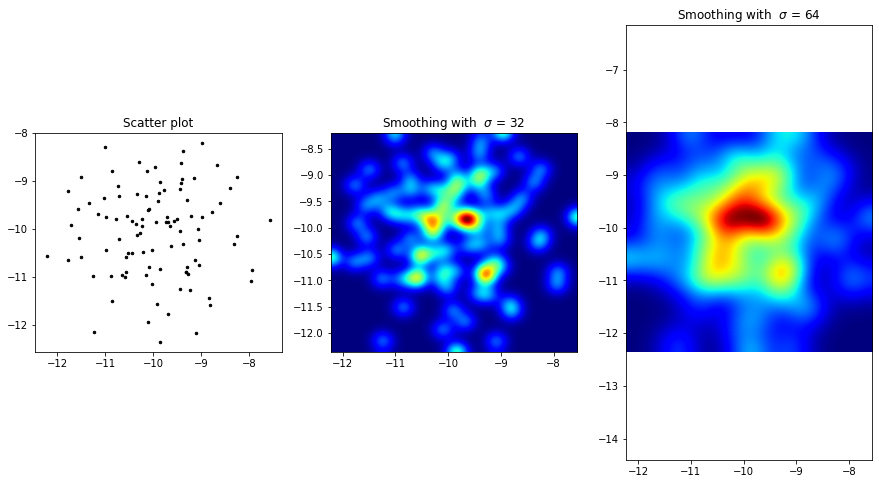

In [15]:
plot.bivariate_hist(log22["x0"])

In [11]:
T = xout22 - log22["x0"]

In [80]:
svgd_adaptive22.newkey()
x0 = svgd_adaptive22.initialize(svgd_adaptive22.rkey)

xout = np.concatenate([xout, x0 + T], axis=0)

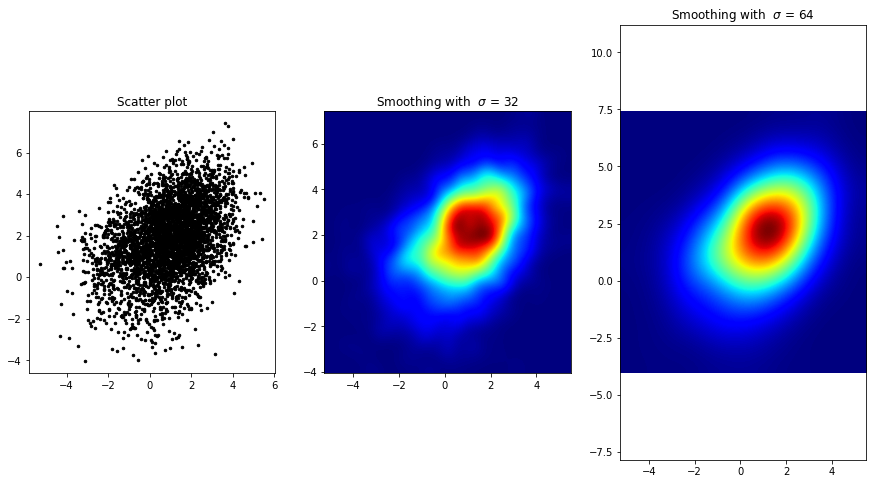

In [81]:
plot.bivariate_hist(xout)

In [82]:
print("var", np.var(xout, axis=0))
print("mean", np.mean(xout, axis=0))

var [2.4298594 2.9020214]
mean [0.9029276 1.9088321]


Compare:

In [84]:
print("var", np.var(xout22, axis=0))
print("mean:", np.mean(xout22, axis=0))

var [1.0337311 2.210293 ]
mean: [0.88810956 1.8170495 ]


# Conclusion
The sampled particles fit the target distribution well (around $0.2$ difference in mean and variance). But when we apply the same transformation to other samples from the same initial distribution $q_0$, the fit to the target distribution is far worse (up to $1.4$ difference). In a sense, the transformation obtained by SVGD overfits the particles used to generate the transformation.